# Load datasets and build one dataset by language

**Datasets:**
1. New round-2 completions (what we have labelled)
2. Old round-1 completions (what we have labelled)
3. Collected from telegram channels (we've collected channels for topics and downloaded posts)
4. Telegram provided labels from r-1 (true labels from round-1 for en and ru)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')


In [2]:
from src.train.predict import load_test_file

## Data prep

In [3]:
COMPLETIONS_R2 = [
    'data/raw/r-2/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/r-2/completions/project-1-at-2021-05-02-05-39-0691dc6b.json',
]

COMPLETIONS_R1 = [
    'data/raw/r-1/completions/2020-02-14_completions.json',
    'data/raw/r-1/completions/2020-02-14_active_completions.json',
]

TG_DOWNLOADS = {
        'META': 'data/raw/r-2/downloads/meta.csv',
        'POSTS': 'data/raw/r-2/downloads/posts.csv',
        'TOPICS': 'data/external/telegram_channels.csv'
    }

TG_TRUE_LABELS = [
    {
        'lang_code': 'en',
        'input': 'data/external/r-1/submission1489/category_en/input.txt',
        'output': 'data/external/r-1/submission1489/category_en/tg_output.txt'
    },
    {
        'lang_code': 'ru',
        'input': 'data/external/r-1/submission1489/category_ru/input.txt',
        'output': 'data/external/r-1/submission1489/category_ru/tg_output.txt'
    },
]

PRIMARY2SECONDARY = 3

In [4]:
def calc_topic_weights(primary, secondary):
    """ create a weight dict from topics """
    total = len(primary) * PRIMARY2SECONDARY + len(secondary)
    weights = {p: PRIMARY2SECONDARY / total for p in primary}
    weights.update({s: 1 / total for s in secondary})
    return weights


def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def raise_non_existent(file):
    raise Exception(f'{file} does not exist')


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    for f in files:
        if not os.path.exists(f):
            raise_non_existent(f)
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data['category'] = labelled_data.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), axis=1)
    labelled_data.drop([
        'primary','secondary', # encoded into `category`
        'subscribers', 'counters', # for now
        'annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display', # from new completions
        "predictions", "score", "posts", # old completions
    ], axis=1, inplace=True, errors='ignore')
    labelled_data.info()
    return labelled_data


def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([
        post.get('text', "") 
        if isinstance(post, dict) else post
        for post in row['recent_posts']
    ])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged


def show_lang_stats(data):
    lang_counts = data['lang_code'].value_counts()
    c = Counter()
    _ = [c.update(cat) for cat in data['category']]
    c = pd.DataFrame(c.most_common(len(c)), columns=['topic','score'])
    fig,axes = plt.subplots(1, 2, figsize=(15,10))
    sns.barplot(x=lang_counts, y=lang_counts.index, ax=axes[1]);
    sns.barplot(x=c['score'],y=c['topic'], ax=axes[0] );

### Load

#### New completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 789
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         800 non-null    object
 1   description   800 non-null    object
 2   recent_posts  800 non-null    object
 3   lang_code     800 non-null    object
 4   id            800 non-null    int64 
 5   category      800 non-null    object
dtypes: int64(1), object(5)
memory usage: 43.8+ KB


,title,description,recent_posts,lang_code,id,category,subset
476,افلام كارتون ديزني || Disney,القليـل مـن الأنمي وكارتون قديم 💕\n\n• لـ AZA...,"[{'type': 'photo', 'text': '#صور_ديزني'}, {'ty...",ar,349,"{'Art & Design': 0.3333333333333333, 'Humor & ...",r-2
742,UNI | BAZAAR 🇺🇿🇷🇺,》 Аккаунт Продажа 🔥\n\n》 Elon berish narxi : 5...,"[{'type': 'video', 'text': '✤Account✤ ✤Sotilad...",uz,49,"{'Offers & Promotions': 0.5, 'Video Games': 0.5}",r-2
59,💔Ý𝖚𝖗𝖆𝖌𝖎𝖒𝖉𝖆 𝖆𝖗𝖒𝖔𝖓𝖎𝖒💔,. ｡*✿∵｡ ｡∵✿*｡\n ｡♥️*ﾟﾟ*♥️∵♥️*ﾟﾟ*♥️...,"[{'type': 'photo', 'text': 'СОҒЛИК энг буюк ҳа...",uz,886,"{'Humor & Memes': 0.3, 'Motivation & Self-deve...",r-2
421,عہالم᭭ الصــہوᯨر🜜,قناه لصور بنات ولد الاولئ والوحيده بالتلكرام ...,"[{'type': 'text', 'text': 'شباب وبنات ليوم نلع...",ar,412,{'Psychology & Relationships': 1.0},r-2


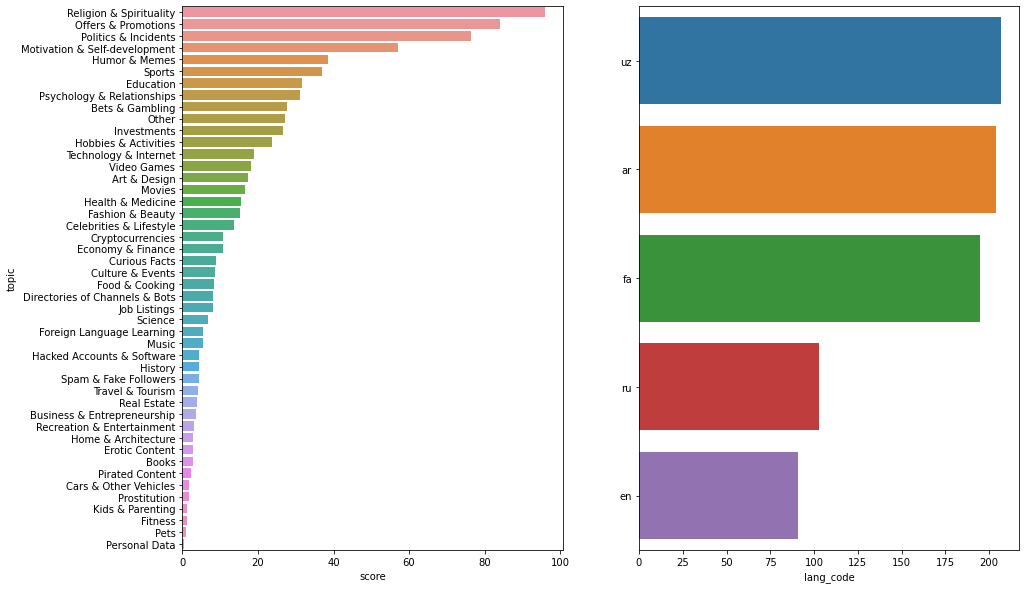

In [5]:
new_labels = load_labelled_data(COMPLETIONS_R2)
new_labels['subset'] = 'r-2'

show_lang_stats(new_labels)

new_labels.sample(4)


#### Old completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   691 non-null    object
 1   lang_code     691 non-null    object
 2   recent_posts  691 non-null    object
 3   title         691 non-null    object
 4   id            691 non-null    int64 
 5   category      691 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.8+ KB


,description,lang_code,recent_posts,title,id,category,subset
136,,ru,[#Ливерпуль_КристалПэлэс ⏰ 2-й Тайм 6:00\n5:7 ...,🔰Чемпионат Англии ( 4 x 4 )🔰,142,{'Sports': 1.0},r-1
259,"👩‍ CA Final DT/IT Notes, Amendments, MCQ & Lec...",en,[🏆 Best Test Series For CA Final 🏆\n ...,P7 DT/IT :- CA FINAL,600,{'Education': 1.0},r-1
90,"Crypto Trading Nicole is a place to be, where ...",en,[Thanks Sami for your kind words towards our w...,Bitcoin Binance Crypto Signals 👩🏼‍💼,75,"{'Cryptocurrencies': 0.75, 'Investments': 0.25}",r-1


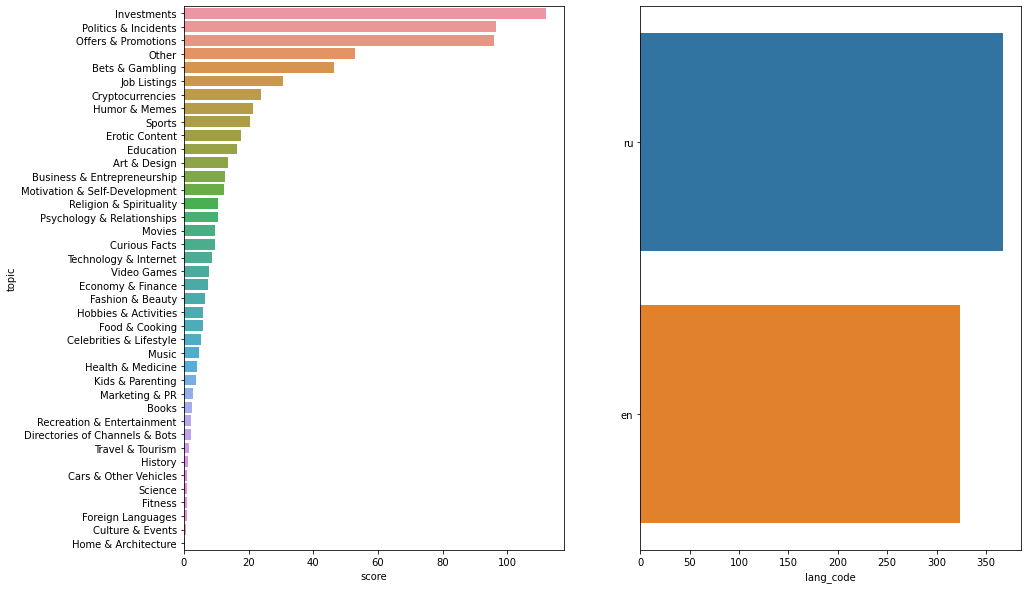

In [6]:
old_labels = load_labelled_data(COMPLETIONS_R1)
old_labels['subset'] = 'r-1'


show_lang_stats(old_labels)

old_labels.sample(3)


#### Tg channel downloads

In [7]:
tg_downloads = pd.DataFrame(load_test_file('data/raw/r-2/downloads/channels.txt'))


# clean
tg_downloads['topic [Secondary]'].fillna("", inplace=True)
# tg_downloads['message'].fillna("", inplace=True)
tg_downloads['description'].fillna("", inplace=True)

# new cols
# topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])
get_lang_code = lambda lang: lang.lower()[:2] if lang != 'Persian' else 'fa'
tg_downloads['lang_code'] = tg_downloads['language'].apply(get_lang_code)

# rename
# posts.rename({'channel':'username', 'message': 'recent_posts'}, axis=1, inplace=True)
# meta.rename({'about':'description',}, axis=1, inplace=True)

# calculate topic weights
tg_downloads['primary'] = tg_downloads['topic [Primary]'].apply(lambda x: x.split(','))
tg_downloads['secondary'] = tg_downloads['topic [Secondary]'].apply(lambda x: x.split(',') if x != '' else [])
tg_downloads['category'] = tg_downloads.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), 
                               axis=1)

# group recent posts
# posts = posts.groupby('username', as_index=False).agg({'recent_posts': lambda row: list(x for x in row if x != '')})


# merge
# tg_downloads = topics[['username','lang_code','category']]\
#             .merge(meta, on=['username'])\
#             .merge(posts, on='username')
tg_downloads['subset'] = 'chan'


del tg_downloads['username']

Loaded 1138 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   language           1138 non-null   object
 1   topic [Primary]    1138 non-null   object
 2   topic [Secondary]  1138 non-null   object
 3   title              1138 non-null   object
 4   description        1138 non-null   object
 5   recent_posts       1138 non-null   object
 6   lang_code          1138 non-null   object
 7   primary            1138 non-null   object
 8   secondary          1138 non-null   object
 9   category           1138 non-null   object
 10  subset             1138 non-null   object
dtypes: object(11)
memory usage: 97.9+ KB


,language,topic [Primary],topic [Secondary],title,description,recent_posts,lang_code,primary,secondary,category,subset
1025,English,Forgery,,Fake ids and real ids,Contact @Ijack42 to buy your fake ids\nreal i...,[if you are in Canada hmu I got business for...,en,[Forgery],[],{'Forgery': 1.0},chan
39,Russian,Books,,книжки на районе,Быть обладателем читательского билета классно....,[книжки на районе\npinned «\nМы привыкли читат...,ru,[Books],[],{'Books': 1.0},chan
306,Russian,Economy & Finance,,Аналитика бизнеса,В любом бизнесе постоянно происходят изменения...,[Россияне увеличили расходы на онлайн-трениров...,ru,[Economy & Finance],[],{'Economy & Finance': 1.0},chan
724,Uzbek,Books,,Мир электронных книг📖📖📖,@mirelektronnihknigcht - наш чат книголюбов\n@...,[],uz,[Books],[],{'Books': 1.0},chan


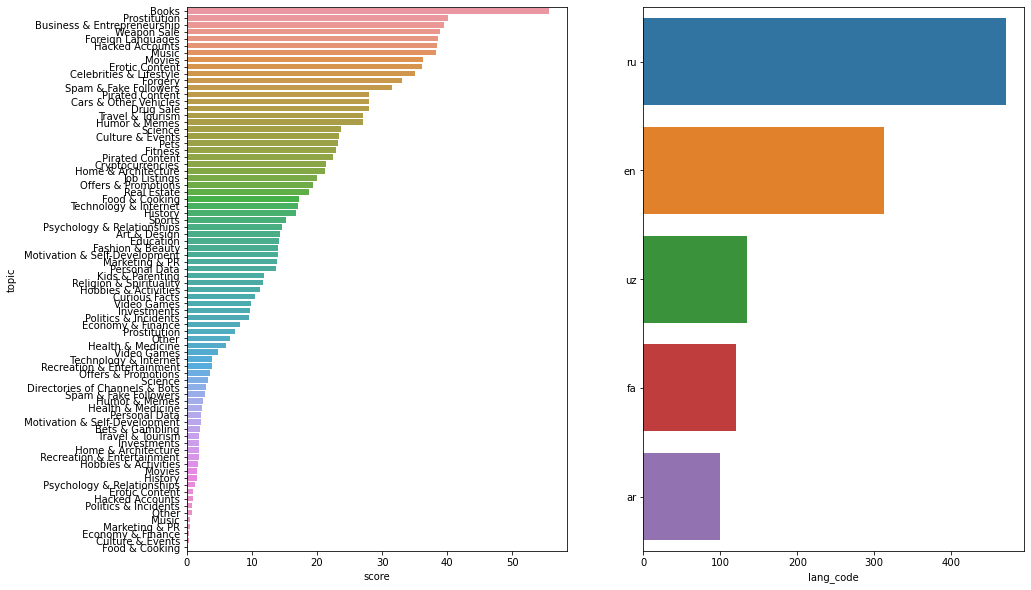

In [8]:
tg_downloads.info()

show_lang_stats(tg_downloads)

tg_downloads.sample(4)


#### Tg true labels

In [9]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict

In [10]:
tg_true = []

for files in TG_TRUE_LABELS:
    inp = load_test_file(files['input'])
    out = load_test_file(files['output'])
    tg_true.extend([update_dict(i, o) for i,o in zip(inp, out)])

    
tg_true = pd.DataFrame(tg_true)

tg_true['subset'] = 'tg'

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31501 entries, 0 to 31500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         31501 non-null  object
 1   description   31501 non-null  object
 2   recent_posts  31501 non-null  object
 3   lang_code     31501 non-null  object
 4   category      31501 non-null  object
 5   subset        31501 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


,title,description,recent_posts,lang_code,category,subset
9718,Success Pictures,👉🏻| EXPRESS your thoughts & feelings through u...,[🤩IF YOU WANT TO BECOME RICH🤩\n\n🏆 THEN READ T...,en,{'Recreation & Entertainment': 0.1428571428571...,tg
5439,Sports Fantasy Guruji,Welcome to one of the India's leading and most...,[PlayerzPot India’s one Of The Best Fantasy Ap...,en,"{'Bets & Gambling': 0.71428571428571, 'Video G...",tg
10961,TARGET Environment Shots,most important content for prelims 2020,"[Cover Complete, Detailed, Targeted and Interl...",en,"{'Offers & Promotions': 0.14285714285714, 'Edu...",tg


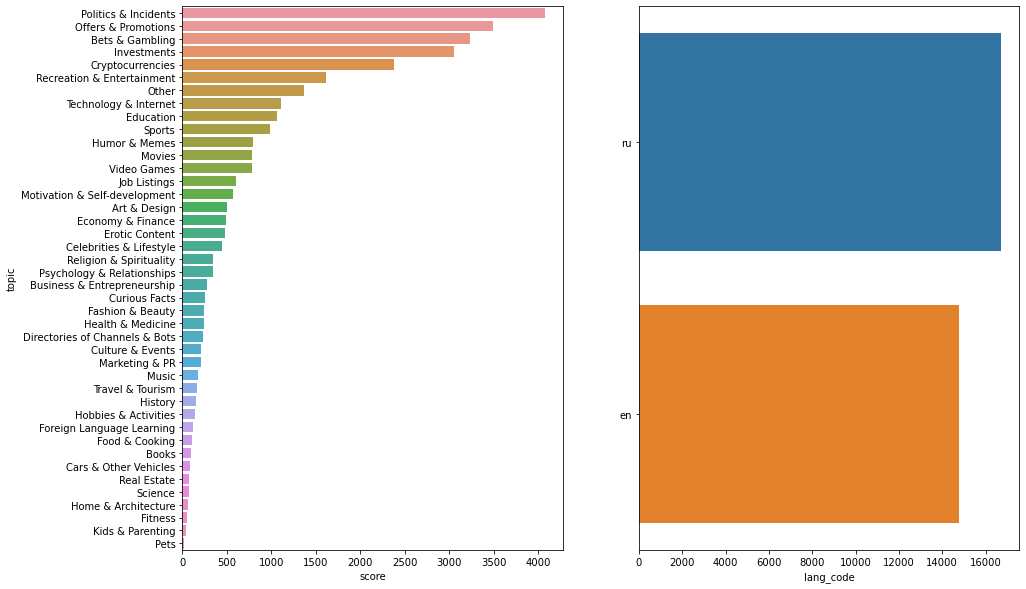

In [11]:
tg_true.info()

show_lang_stats(tg_true)

tg_true.sample(3)

## Combine and save

### concat

In [12]:
comb = pd.concat([
    new_labels,
    old_labels,
    tg_downloads,
    tg_true,

], axis=0)
comb.shape

(34130, 12)

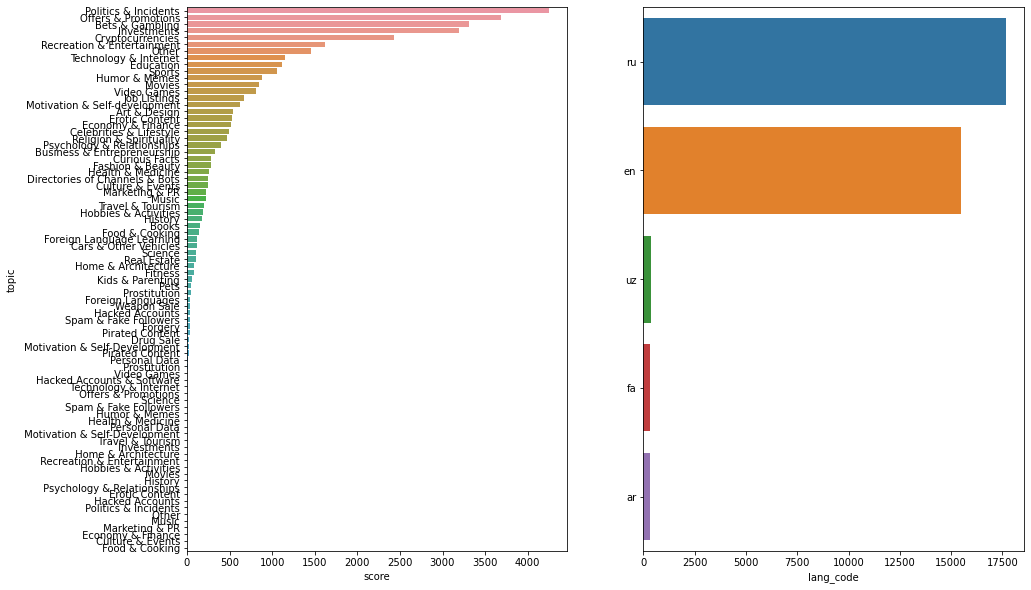

In [13]:
show_lang_stats(comb)

In [14]:
comb['subset'].value_counts()

tg      31501
chan     1138
r-2       800
r-1       691
Name: subset, dtype: int64

### get raw texts

In [15]:
comb['text'] = comb.apply(prepare_text, axis=1)

### Save

In [16]:
comb.shape


(34130, 13)

In [17]:
comb.to_csv('data/interim/train_data.csv', index=False)